# NDVI Panel (2016–2025)

Visualize clipped NDVI rasters for Brahmanbaria across years in a 2×5 panel (2016–2025). Each NDVI is read from `map/<year>/brahmanbaria_ndvi_<yyyymmdd>.tif` if present. Downsampling is applied to keep memory use reasonable.


In [1]:
import sys
from pathlib import Path

# notebooks/ → project root
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import src.geo_env   # MUST come immediately after path fix


In [2]:
import re
from pathlib import Path
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import transform_bounds
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


In [3]:

# Resolve project root (tries cwd, then parent)
base = Path.cwd()
if (base / "map").exists():
    project_root = base
elif (base.parent / "map").exists():
    project_root = base.parent
else:
    project_root = base  # fallback

map_dir = project_root / "map"
years = list(range(2016, 2026))
scale_factor = 4  # 1=full res; larger numbers downsample more

# NDVI class breaks and labels
bounds = [-0.5, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.5]
hex_colors = ["#08306B", "#D9D9D9", "#FEE391", "#A6D96A", "#66BD63", "#1A9850", "#006837"]
labels = [
    "< 0 (Water/Snow/Clouds)",
    "0–0.1 (Bare/Urban)",
    "0.1–0.2 (Very Sparse)",
    "0.2–0.4 (Sparse–Moderate)",
    "0.4–0.6 (Moderate)",
    "0.6–0.8 (Dense)",
    "> 0.8 (Very Dense)",
]

cmap = ListedColormap(hex_colors)
norm = BoundaryNorm(bounds, cmap.N)
ticks = [(-0.5 + 0) / 2, (0 + 0.1) / 2, (0.1 + 0.2) / 2, (0.2 + 0.4) / 2,
         (0.4 + 0.6) / 2, (0.6 + 0.8) / 2, (0.8 + 1.5) / 2]


In [4]:

def load_ndvi(year: int, sf: int = 4):
    year_dir = map_dir / str(year)
    candidates = sorted(year_dir.glob("brahmanbaria_ndvi_*.tif"))
    if not candidates:
        return None
    path = candidates[0]
    m = re.search(r"(\d{8})", path.name)
    date_str = m.group(1) if m else "yyyyMMdd"
    with rasterio.open(path) as src:
        out_height = max(1, src.height // sf)
        out_width = max(1, src.width // sf)
        data = src.read(1, out_shape=(out_height, out_width), resampling=Resampling.average)
        data = np.ma.masked_invalid(data)
        lon_min, lat_min, lon_max, lat_max = transform_bounds(src.crs, "EPSG:4326", *src.bounds)
    pad_frac = 0.02
    pad_lon = (lon_max - lon_min) * pad_frac
    pad_lat = (lat_max - lat_min) * pad_frac
    extent = [lon_min - pad_lon, lon_max + pad_lon, lat_min - pad_lat, lat_max + pad_lat]
    return {
        "data": data,
        "extent": extent,
        "date": date_str,
        "path": path,
    }


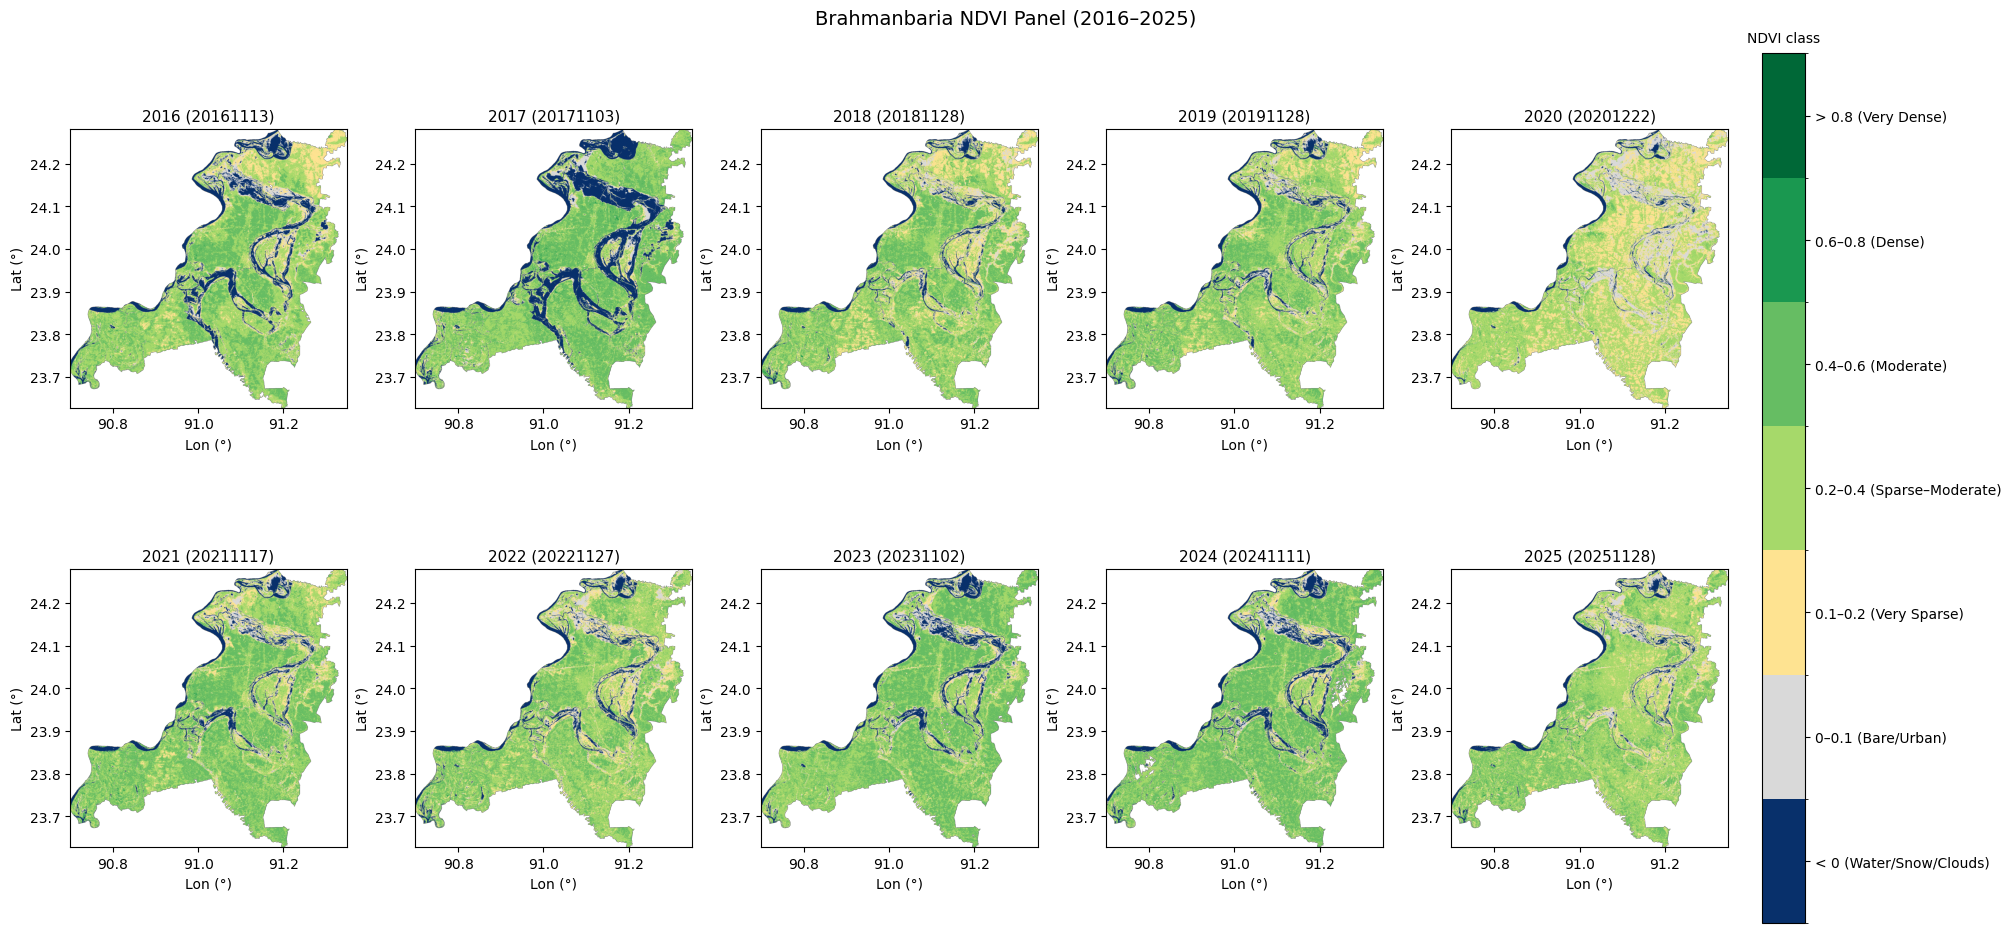

In [5]:

fig, axes = plt.subplots(2, 5, figsize=(20, 9), constrained_layout=True)
axes = axes.ravel()
last_im = None

for ax, year in zip(axes, years):
    ndvi_info = load_ndvi(year, sf=scale_factor)
    if ndvi_info is None:
        ax.axis("off")
        ax.set_title(f"{year}: missing", fontsize=11)
        continue
    im = ax.imshow(ndvi_info["data"], cmap=cmap, norm=norm, extent=ndvi_info["extent"], origin="upper")
    last_im = im
    ax.set_title(f"{year} ({ndvi_info['date']})", fontsize=11)
    ax.set_xlabel("Lon (°)")
    ax.set_ylabel("Lat (°)")

if last_im is not None:
    cbar = fig.colorbar(last_im, ax=axes, boundaries=bounds, ticks=ticks, fraction=0.035, pad=0.02)
    cbar.ax.set_yticklabels(labels)
    cbar.ax.set_title("NDVI class", pad=8, fontsize=10)

plt.suptitle("Brahmanbaria NDVI Panel (2016–2025)", fontsize=14, y=1.02)
plt.show()
